https://github.com/pierrexyz/fftlog/tree/master

In [19]:
import os, sys
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np
from fftlog.fftlog import FFTLog
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

In [20]:
from classy import Class
cosmo=Class()
z_pk = 0.

cosmo.set({'output':'mPk',\
          'non linear':'none',
           'P_k_max_1/Mpc':1.0,
          'z_pk':z_pk})
cosmo.compute()

k = np.logspace(-4,0, 1000) # 1/Mpc
#rvec = np.logspace(np.log10(r.min()),np.log10(r.max()),1000)
rvec = np.logspace(np.log10(0.01),np.log10(1000),1000)
pkline=np.array([cosmo.pk_lin(ki,z_pk) for ki in k])
ipk_lin = Spline(k,pkline)

In [21]:
fftsettings = dict(Nmax=128, xmin=1e-5, xmax=1e3, bias=-0.01, window=0.2)
fft = FFTLog(**fftsettings)

In [22]:
Coef = fft.Coef(k, ipk_lin(k)) # get the c_\alpha
P11 = np.array([np.real(np.sum(Coef * ki**fft.Pow)) for ki in k])

[]

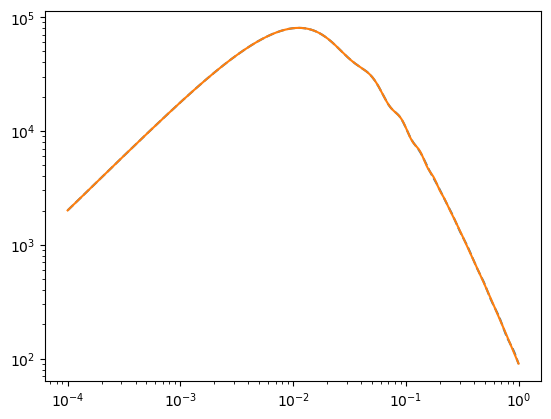

In [23]:
plt.plot(k,P11,'--')
plt.plot(k,ipk_lin(k))
plt.loglog()

In [24]:
from scipy.special import gamma, loggamma
def I(nu1,nu2):
    return 1/8/np.pi**(3/2)*gamma(1.5-nu1)*gamma(1.5-nu2)*gamma(nu1+nu2-1.5)/gamma(nu1)/gamma(nu2)/gamma(3-nu1-nu2)
def Msigma(nu1_,nu2_,sigma):
    nu1,nu2=np.meshgrid(nu1_,nu2_)
    nu12 = nu1+nu2
    if sigma=='22':
        return (1.5-nu1-nu2)*(0.5-nu1-nu2)*(nu1*nu2*(98*nu12**2-14*nu12+36)-91*nu12**2+3*nu12+58)/(196*nu1*(1+nu1)*(0.5-nu1)*nu2*(1+nu2)*(0.5-nu2))*I(nu1,nu2)

    elif sigma=='13':
        return (1+9*nu1)/4*np.tan(nu1*np.pi)/(28*np.pi*(nu1+1)*nu1*(nu1-1)*(nu1-2)*(nu1-3))

In [25]:
cm1 = fft.Coef(k, ipk_lin(k))
nu1 = fft.Pow/(-2)
cm2 = fft.Coef(k, ipk_lin(k))
nu2 = fft.Pow/(-2)

(1000, 129)

In [34]:
# k_pow1 = k[:, None]**(-2*nu1)
# k_pow2 = k[:, None]**(-2*nu2)

k_pow1 = np.exp(np.einsum('k,i->ki',np.log(k),-2*nu1))
k_pow2 = np.exp(np.einsum('k,i->ki',np.log(k),-2*nu2))

M22 = Msigma(nu1, nu2, sigma='22')
M13 = Msigma(nu1, nu2, sigma='13')

P22 = k**3 * np.einsum('ki,ij,kj,i,j->k', k_pow1, M22, k_pow2, cm1, cm2)
P13 = k**3 * np.einsum('ki,ij,kj,i,j->k', k_pow1, M13, k_pow2, cm1, cm2)
Pct = lambda k,P11,cs2: -4*np.pi*cs2*k**2*P11

/Users/zhiyulu/Install/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/zhiyulu/Install/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


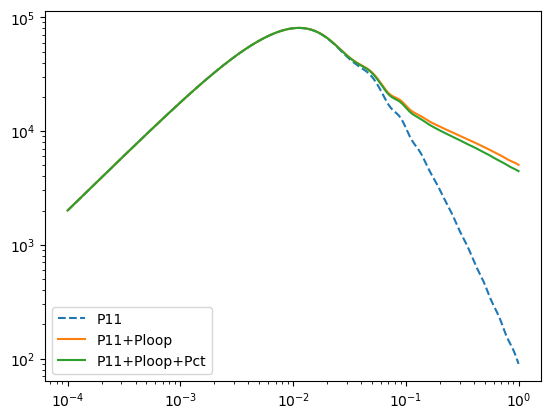

In [35]:
plt.plot(k,P11,'--',label='P11')
plt.plot(k,P11+P22+P13,label='P11+Ploop')
plt.plot(k,P11+P22+P13+Pct(k,pk_rec,1),label='P11+Ploop+Pct')
plt.loglog()
plt.legend()
#plt.xlim(5e-3,0.3)